## Descrizione del problema
Si vuole capire quanto sia conveniente coltivare del frumento tenero in determinato terreno di cui si conoscono alcune caratteristiche come: posizione geografica (altitudine, latitudine, longitudine), dimensione del terreno in ettari e infine dati meteorologici annuali (precipitazioni e temperatura media).
La previsione della produzione annua in quintali di frumento tenero per il terreno descritto permetterà di valutare l'efficienza e la redditività della coltivazione in quel particolare contesto.

## Motivazione del problema
L'agricoltura è un settore cruciale per l'economia e la sicurezza alimentare. Con le variazioni climatiche e le differenze geografiche che influenzano significativamente le rese agricole, è essenziale fornire agli agricoltori strumenti predittivi accurati. La capacità di prevedere la produzione di frumento tenero in base a dati specifici del terreno e condizioni meteorologiche può aiutare gli agricoltori a prendere decisioni informate, ottimizzare l'uso delle risorse, e migliorare la pianificazione delle colture per massimizzare i rendimenti e la sostenibilità.
##  Soluzione Proposta
La soluzione proposta è un modello di regressione addestrato con un dataset contenente dati geografici di  comuni italiani, dati sui terreni (superficie e produzione) e dati meteorologici su base annua (dal 2006 al 2021).
Il modello, una volta addestrato, sarà utilizzato per effettuare previsioni sulla produzione di frumento tenero basate su dati forniti dall'utente. L'utente può inserire questi dati tramite una Web App sviluppata in Flask, che permette di inviare le caratteristiche del terreno e ricevere una previsione della produzione annua.

###  Sfide informatiche affrontate
1. Modellazione del problema:  Identificazione delle caratteristiche rilevanti e scelta del modello di regressione appropriato.
2. Normalizzazione delle features dei datasets (effettuata in altri notebook)
3. Utilizzo di Shap per l'analisi del peso delle features per interpretare l'importanza di ciascuna variabile nel modello.
4. Analisi del comportamento dei modelli: Valutazione delle prestazioni dei modelli di regressione e scelta del miglior modello basato sulle metriche di valutazione.

### Metodo proposto
1. Caricamento del dataset ottenuto dopo tutte le operazioni di pre - processing
2. Suddivisione del dataset in features (di seguito, la variabile X) e target (di seguito, y)
3. Utilizzo di K - Fold Cross Validation per effettuare una cross validation
4. Addestramento con Random Regressor, Linear Regression, Linear SVR e K-Nearest Neighbors.
5. Calcolo delle metriche di regressione per ogni regressore: Mean Squared Error, Root Mean Squared Error, Mean Absolute Error, R-squared, Mean Absolute Percentage Error
6. Salvataggio su file del modello
7. Plotting delle liste delle metriche di regressione per ogni fold
8. Utilizzo del framework Shap per valutare il peso delle singole features del dataset

In [9]:
import shap
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**Definizione della funzione `plot_bar_chart`**: questa funzione prende in input una lista di punteggi di una metrica (`metric_scores`) e il nome della metrica (`metric_name`). La funzione crea un grafico a barre che mostra i valori della metrica per ogni fold della cross-validation.

In [10]:
# Funzione per creare un bar chart per ogni fold, servirà più avanti
def plot_bar_chart(metric_scores, metric_name, model_name):
    plt.figure(figsize=(8, 3))
    plt.bar(range(1, len(metric_scores) + 1), metric_scores, color='skyblue')
    plt.xlabel('Fold Number')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} per Fold - {model_name}')
    plt.xticks(range(1, len(metric_scores) + 1))
    plt.show()

### Composizione dataset dataset_final.csv:
1. **alt, lat, lon**: coordinate geografiche di ogni comune italiano
2. **anno**: anno di riferimento.
3. **superficie totale - ettari**: superficie coltivata in ettari in uno specifico anno.
4. **produzione totale - quintali**: produzione in quintali in uno specifico anno.
5. **prec mm**: precipitazioni medie in millimetri nell'anno di riferimento.
6. **temp cel**: temperatura media nell'anno di riferimento.

In [11]:
# Carica i dati
features = pd.read_csv("../../data/processed/dataset_final.csv")

# Seleziona le caratteristiche e il target
X = features[['alt', 'lat', 'lon', 'superficie totale - ettari', 'prec mm', 'temp cel']]

# Rinomino le colonne per comodità, per avere coerenza di nomi delle colonne nel modello da utilizzare nell'app
X = X.rename(columns={
    'superficie totale - ettari': 'superficie',
    'prec mm': 'prec',
    'temp cel': 'temp'
})

y = features['produzione totale - quintali']

# Visualizza dataset
display(features)
display(X)
display(y)

,Unnamed: 0,comune,provincia,alt,lat,lon,anno,superficie totale - ettari,produzione totale - quintali,prec mm,temp cel
0,0,Abano Terme,padova,45.0,45.359387,11.788713,2006,11453.0,803222.0,862.4,14.44
1,1,Abbadia Cerreto,lodi,64.0,45.312391,9.592525,2006,2780.0,194600.0,481.0,14.09
2,2,Abbadia Lariana,lecco,909.0,45.900500,9.334549,2006,270.0,13500.0,1048.8,14.58
3,3,Abbadia San Salvatore,siena,1021.5,42.880969,11.677506,2006,11500.0,368000.0,697.2,14.65
4,4,Abbasanta,oristano,377.5,40.123903,8.821022,2006,3600.0,194600.0,481.0,14.65
...,...,...,...,...,...,...,...,...,...,...,...
106715,106715,Zuglio,udine,1076.5,46.460954,13.026428,2021,276.0,6900.0,1098.2,14.40
106716,106716,Zumaglia,biella,551.5,45.594785,8.088702,2021,349.0,15356.0,1112.8,14.07
106717,106717,Zumpano,cosenza,343.5,39.310632,16.293506,2021,6327.0,188538.0,1122.8,16.36
106718,106718,Zungoli,avellino,688.5,41.127660,15.202556,2021,5200.0,234000.0,1261.0,15.62


,alt,lat,lon,superficie,prec,temp
0,45.0,45.359387,11.788713,11453.0,862.4,14.44
1,64.0,45.312391,9.592525,2780.0,481.0,14.09
2,909.0,45.900500,9.334549,270.0,1048.8,14.58
3,1021.5,42.880969,11.677506,11500.0,697.2,14.65
4,377.5,40.123903,8.821022,3600.0,481.0,14.65
...,...,...,...,...,...,...
106715,1076.5,46.460954,13.026428,276.0,1098.2,14.40
106716,551.5,45.594785,8.088702,349.0,1112.8,14.07
106717,343.5,39.310632,16.293506,6327.0,1122.8,16.36
106718,688.5,41.127660,15.202556,5200.0,1261.0,15.62


0         803222.0
1         194600.0
2          13500.0
3         368000.0
4         194600.0
            ...   
106715      6900.0
106716     15356.0
106717    188538.0
106718    234000.0
106719     34800.0
Name: produzione totale - quintali, Length: 106720, dtype: float64

In [12]:
# Inizializza liste per gli scores
rf_mse_scores = []
rf_rmse_scores = []
rf_mae_scores = []
rf_r_squared_scores = []
rf_mape_scores = []

lr_mse_scores = []
lr_rmse_scores = []
lr_mae_scores = []
lr_r_squared_scores = []
lr_mape_scores = []

svr_mse_scores = []
svr_rmse_scores = []
svr_mae_scores = []
svr_r_squared_scores = []
svr_mape_scores = []

knn_mse_scores = []
knn_rmse_scores = []
knn_mae_scores = []
knn_r_squared_scores = []
knn_mape_scores = []

In [13]:
# Inizializza il K-Fold Cross Validation
kf = KFold(n_splits=20, shuffle=True, random_state=42)

print("Training models...")

# Utilizza tqdm per mostrare una barra di avanzamento
for i, (train_index, test_index) in enumerate(tqdm(kf.split(X), total=kf.get_n_splits())):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train modello con RandomForest
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    
    # Calcola gli scores
    rf_mse = mean_squared_error(y_test, rf_predictions)
    rf_rmse = np.sqrt(rf_mse)
    rf_mae = mean_absolute_error(y_test, rf_predictions)
    rf_r_squared = r2_score(y_test, rf_predictions)
    rf_mape = np.mean(np.abs((y_test - rf_predictions) / y_test)) * 100
    
    rf_mse_scores.append(rf_mse)
    rf_rmse_scores.append(rf_rmse)
    rf_mae_scores.append(rf_mae)
    rf_r_squared_scores.append(rf_r_squared)
    rf_mape_scores.append(rf_mape)
    
    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_test)
    
    lr_mse = mean_squared_error(y_test, lr_predictions)
    lr_rmse = np.sqrt(lr_mse)
    lr_mae = mean_absolute_error(y_test, lr_predictions)
    lr_r_squared = r2_score(y_test, lr_predictions)
    lr_mape = np.mean(np.abs((y_test - lr_predictions) / y_test)) * 100
    
    lr_mse_scores.append(lr_mse)
    lr_rmse_scores.append(lr_rmse)
    lr_mae_scores.append(lr_mae)
    lr_r_squared_scores.append(lr_r_squared)
    lr_mape_scores.append(lr_mape)
    
    # Support Vector Regression
    svr_model = LinearSVR()
    svr_model.fit(X_train, y_train)
    svr_predictions = svr_model.predict(X_test)
    
    svr_mse = mean_squared_error(y_test, svr_predictions)
    svr_rmse = np.sqrt(svr_mse)
    svr_mae = mean_absolute_error(y_test, svr_predictions)
    svr_r_squared = r2_score(y_test, svr_predictions)
    svr_mape = np.mean(np.abs((y_test - svr_predictions) / y_test)) * 100
    
    svr_mse_scores.append(svr_mse)
    svr_rmse_scores.append(svr_rmse)
    svr_mae_scores.append(svr_mae)
    svr_r_squared_scores.append(svr_r_squared)
    svr_mape_scores.append(svr_mape)
    
    # K-Nearest Neighbors Regression
    knn_model = KNeighborsRegressor()
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    
    knn_mse = mean_squared_error(y_test, knn_predictions)
    knn_rmse = np.sqrt(knn_mse)
    knn_mae = mean_absolute_error(y_test, knn_predictions)
    knn_r_squared = r2_score(y_test, knn_predictions)
    knn_mape = np.mean(np.abs((y_test - knn_predictions) / y_test)) * 100
    
    knn_mse_scores.append(knn_mse)
    knn_rmse_scores.append(knn_rmse)
    knn_mae_scores.append(knn_mae)
    knn_r_squared_scores.append(knn_r_squared)
    knn_mape_scores.append(knn_mape)

Training models...


  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\valde\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\valde\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
  5%|▌         | 1/20 [00:41<13:11, 41.68s/it]C:\Users\valde\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\valde\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 10%|█         | 2/20 [01:22<1

## Stampa dei risultati

In [14]:
rf_mean_mse = np.mean(rf_mse_scores)
rf_mean_rmse = np.mean(rf_rmse_scores)
rf_mean_mae = np.mean(rf_mae_scores)
rf_mean_r_squared = np.mean(rf_r_squared_scores)
rf_mean_mape = np.mean(rf_mape_scores)

# Calcola la media delle metriche per ogni modello
lr_mean_mse = np.mean(lr_mse_scores)
lr_mean_rmse = np.mean(lr_rmse_scores)
lr_mean_mae = np.mean(lr_mae_scores)
lr_mean_r_squared = np.mean(lr_r_squared_scores)
lr_mean_mape = np.mean(lr_mape_scores)

svr_mean_mse = np.mean(svr_mse_scores)
svr_mean_rmse = np.mean(svr_rmse_scores)
svr_mean_mae = np.mean(svr_mae_scores)
svr_mean_r_squared = np.mean(svr_r_squared_scores)
svr_mean_mape = np.mean(svr_mape_scores)

knn_mean_mse = np.mean(knn_mse_scores)
knn_mean_rmse = np.mean(knn_rmse_scores)
knn_mean_mae = np.mean(knn_mae_scores)
knn_mean_r_squared = np.mean(knn_r_squared_scores)
knn_mean_mape = np.mean(knn_mape_scores)

print("------------------------ RANDOM FOREST SCORES ------------------------")
print("Mean Squared Error (MSE): ", rf_mean_mse)
print("Root Mean Squared Error (RMSE): ", rf_mean_rmse)
print("Mean Absolute Error (MAE): ", rf_mean_mae)
print("R-squared (R²): ", rf_mean_r_squared)
print("Mean Absolute Percentage Error (MAPE): ", rf_mean_mape)
print("----------------------------------------------------------------------")

print("---------------------- LINEAR REGRESSION SCORES ----------------------")
print(f"Mean Squared Error (MSE): {lr_mean_mse}")
print(f"Root Mean Squared Error (RMSE): {lr_mean_rmse}")
print(f"Mean Absolute Error (MAE): {lr_mean_mae}")
print(f"R-squared (R²): {lr_mean_r_squared}")
print(f"Mean Absolute Percentage Error (MAPE): {lr_mean_mape}")
print("----------------------------------------------------------------------")

print("----------------------------- SVR SCORES -----------------------------")
print(f"Mean Squared Error (MSE): {svr_mean_mse}")
print(f"Root Mean Squared Error (RMSE): {svr_mean_rmse}")
print(f"Mean Absolute Error (MAE): {svr_mean_mae}")
print(f"R-squared (R²): {svr_mean_r_squared}")
print(f"Mean Absolute Percentage Error (MAPE): {svr_mean_mape}")
print("----------------------------------------------------------------------")

print("----------------------------- KNN SCORES -----------------------------")
print(f"Mean Squared Error (MSE): {knn_mean_mse}")
print(f"Root Mean Squared Error (RMSE): {knn_mean_rmse}")
print(f"Mean Absolute Error (MAE): {knn_mean_mae}")
print(f"R-squared (R²): {knn_mean_r_squared}")
print(f"Mean Absolute Percentage Error (MAPE): {knn_mean_mape}")
print("----------------------------------------------------------------------")

------------------------ RANDOM FOREST SCORES ------------------------
Mean Squared Error (MSE):  7554384.291063231
Root Mean Squared Error (RMSE):  2609.87256574607
Mean Absolute Error (MAE):  136.91067082083956
R-squared (R²):  0.9999730602670611
Mean Absolute Percentage Error (MAPE):  0.05604378130231484
----------------------------------------------------------------------
---------------------- LINEAR REGRESSION SCORES ----------------------
Mean Squared Error (MSE): 13270474763.333942
Root Mean Squared Error (RMSE): 115184.46565014953
Mean Absolute Error (MAE): 71004.42598408696
R-squared (R²): 0.9528258396783326
Mean Absolute Percentage Error (MAPE): 5347.5743434685955
----------------------------------------------------------------------
----------------------------- SVR SCORES -----------------------------
Mean Squared Error (MSE): 20803100798.401978
Root Mean Squared Error (RMSE): 139054.84058007383
Mean Absolute Error (MAE): 78317.45619674424
R-squared (R²): 0.92668116572259

## Salvataggio modello su file, per poterlo utilizzare con la Web App in Flask

In [15]:
# Salva il modello addestrato
print("Saving Random Forest model...")
joblib.dump(rf_model, '../../models/rf_harvest_model_all_data.pkl')
print("Random Forest model saved!")

print("Saving Linear Regression model...")
joblib.dump(lr_model, '../../models/lr_harvest_model_all_data.pkl')
print("Linear Regression model saved!")

print("Saving Linear SVR model...")
joblib.dump(svr_model, '../../models/svr_harvest_model_all_data.pkl')
print("Linear Regression model saved!")

print("Saving KNN model...")
joblib.dump(knn_model, '../../models/knn_harvest_model_all_data.pkl')
print("Linear Regression model saved!")

Saving Random Forest model...
Random Forest model saved!
Saving Linear Regression model...
Linear Regression model saved!
Saving Linear SVR model...
Linear Regression model saved!
Saving KNN model...
Linear Regression model saved!


## Plot dei risultati
**Creazione dei grafici a barre per ogni metrica**: si chiama la funzione `plot_bar_chart` per creare grafici a barre per ogni metrica.

I grafici possono essere utili per l'identificazione di eventuali variazioni significative nelle prestazioni tra i diversi fold, permettendo di:
- Valutare la stabilità e la consistenza del modello.
- Individuare eventuali outlier o anomalie nelle prestazioni.
- Comunicare in modo efficace i risultati delle valutazioni del modello.

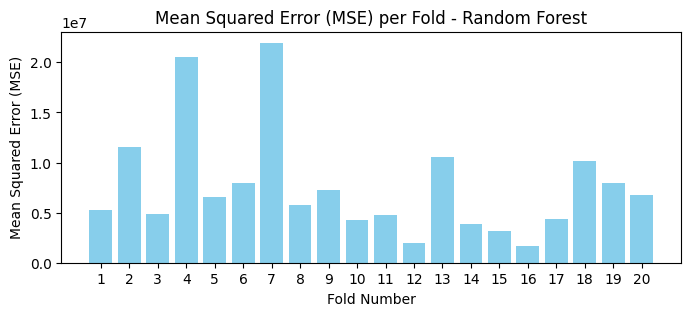

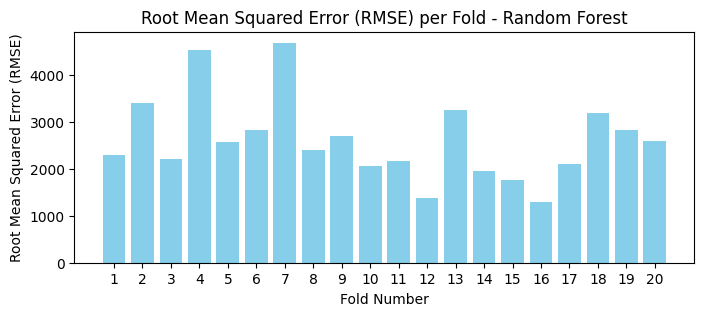

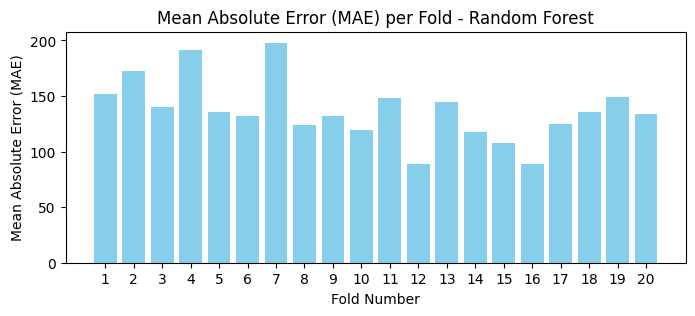

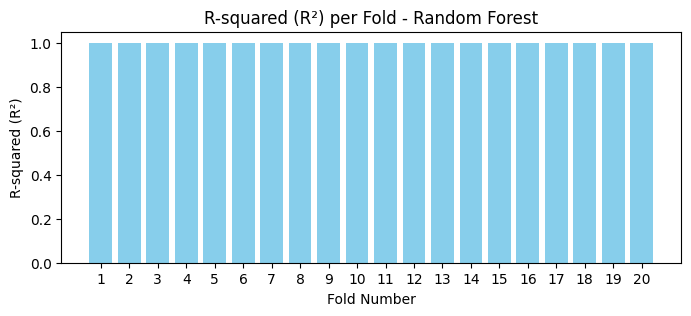

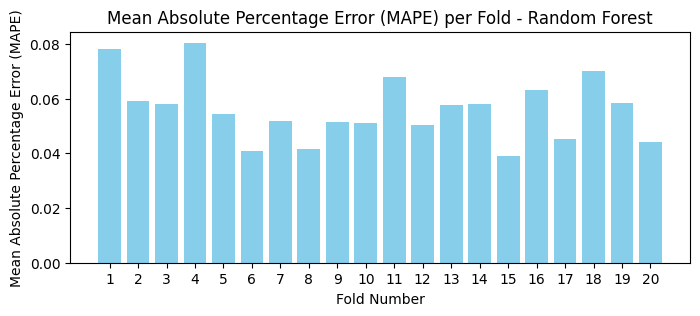

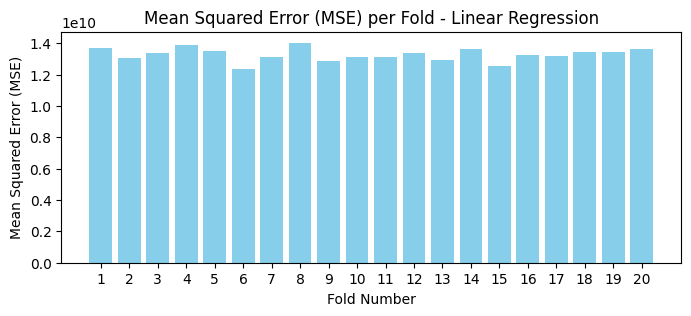

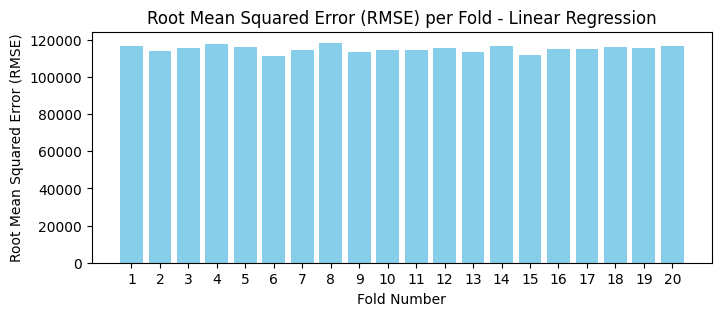

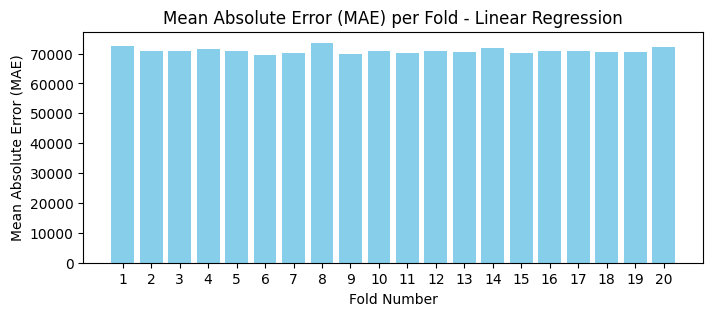

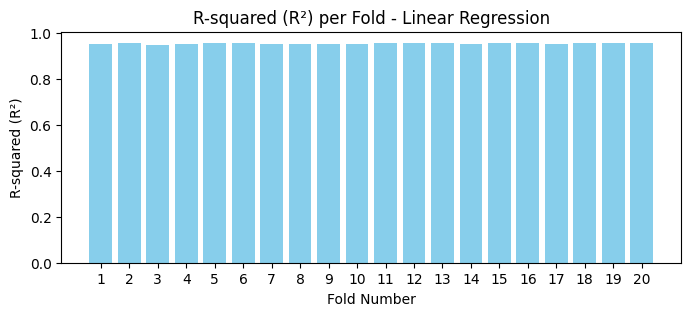

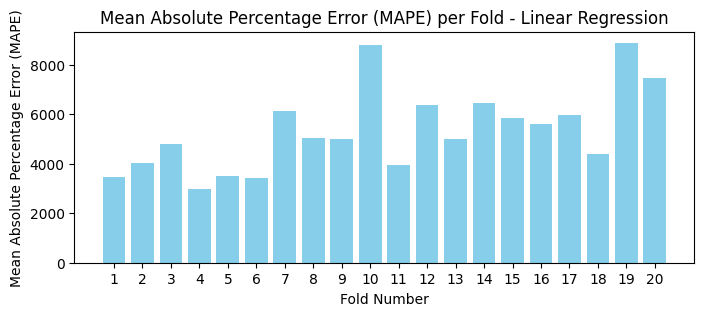

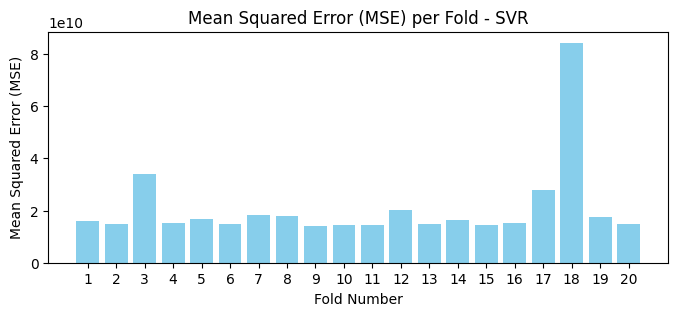

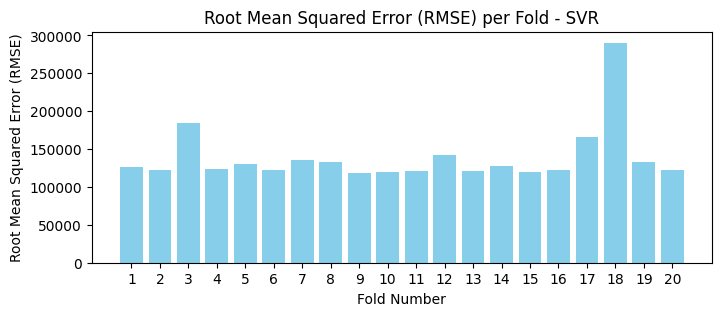

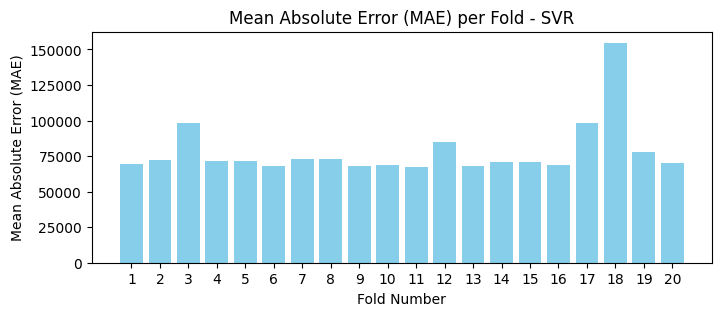

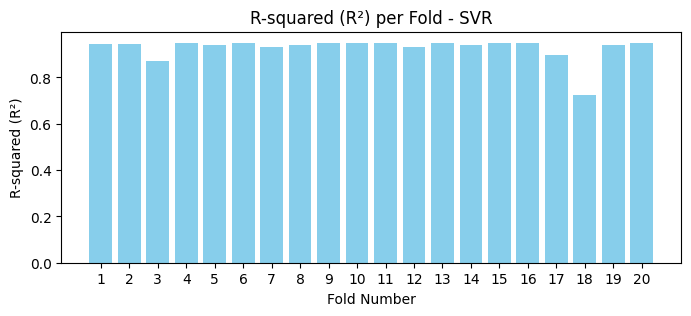

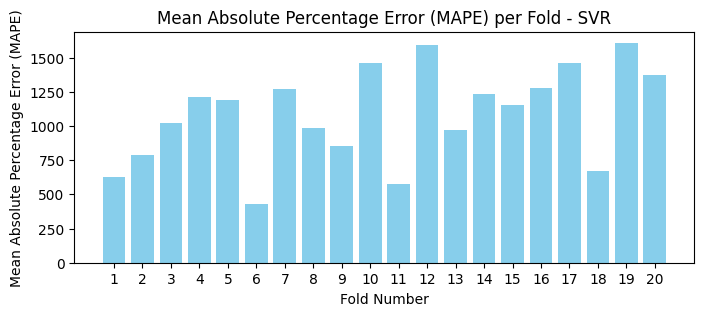

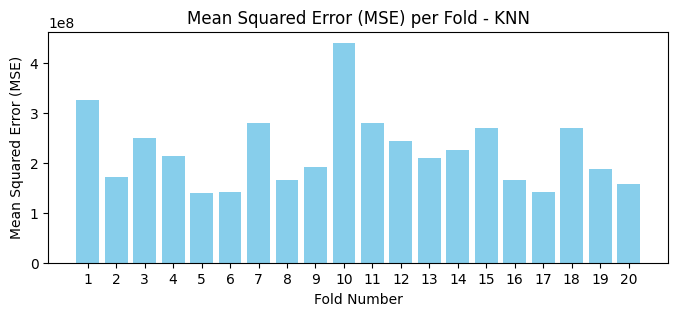

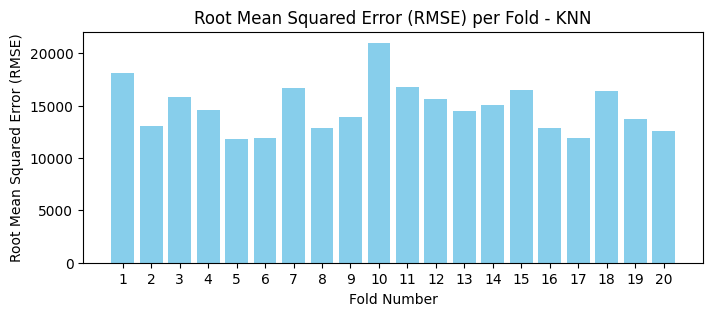

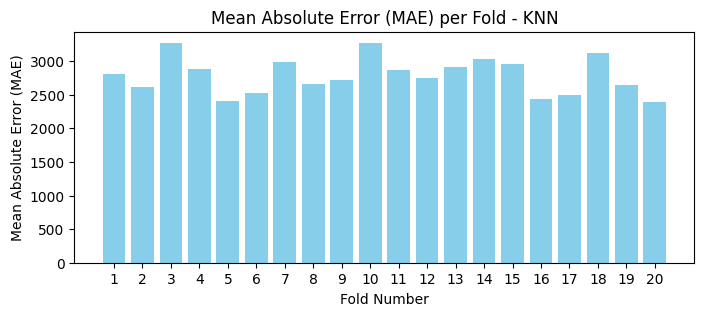

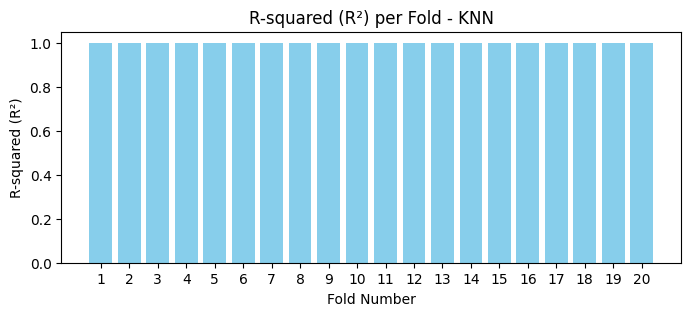

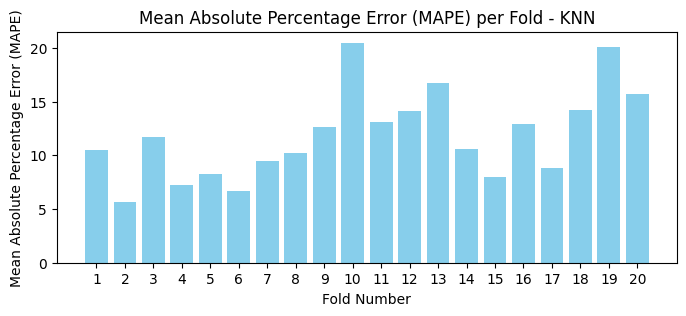

In [16]:
# Plot delle metriche per Random Forest
plot_bar_chart(rf_mse_scores, 'Mean Squared Error (MSE)', 'Random Forest')
plot_bar_chart(rf_rmse_scores, 'Root Mean Squared Error (RMSE)', 'Random Forest')
plot_bar_chart(rf_mae_scores, 'Mean Absolute Error (MAE)', 'Random Forest')
plot_bar_chart(rf_r_squared_scores, 'R-squared (R²)', 'Random Forest')
plot_bar_chart(rf_mape_scores, 'Mean Absolute Percentage Error (MAPE)', 'Random Forest')

# Plot delle metriche per Linear Regression
plot_bar_chart(lr_mse_scores, 'Mean Squared Error (MSE)', 'Linear Regression')
plot_bar_chart(lr_rmse_scores, 'Root Mean Squared Error (RMSE)', 'Linear Regression')
plot_bar_chart(lr_mae_scores, 'Mean Absolute Error (MAE)', 'Linear Regression')
plot_bar_chart(lr_r_squared_scores, 'R-squared (R²)', 'Linear Regression')
plot_bar_chart(lr_mape_scores, 'Mean Absolute Percentage Error (MAPE)', 'Linear Regression')

# Plot delle metriche per SVR
plot_bar_chart(svr_mse_scores, 'Mean Squared Error (MSE)', 'SVR')
plot_bar_chart(svr_rmse_scores, 'Root Mean Squared Error (RMSE)', 'SVR')
plot_bar_chart(svr_mae_scores, 'Mean Absolute Error (MAE)', 'SVR')
plot_bar_chart(svr_r_squared_scores, 'R-squared (R²)', 'SVR')
plot_bar_chart(svr_mape_scores, 'Mean Absolute Percentage Error (MAPE)', 'SVR')

# Plot delle metriche per KNN
plot_bar_chart(knn_mse_scores, 'Mean Squared Error (MSE)', 'KNN')
plot_bar_chart(knn_rmse_scores, 'Root Mean Squared Error (RMSE)', 'KNN')
plot_bar_chart(knn_mae_scores, 'Mean Absolute Error (MAE)', 'KNN')
plot_bar_chart(knn_r_squared_scores, 'R-squared (R²)', 'KNN')
plot_bar_chart(knn_mape_scores, 'Mean Absolute Percentage Error (MAPE)', 'KNN')

## Utilizzo della libreria SHAP
I bar plot e i beeswarm plot generati con SHAP servono per interpretare l'importanza di ogni feature per un modello.

### SHAP Bar Plot
Un bar plot visualizza l'importanza globale delle caratteristiche del modello.

* SHAP values: rappresentano l'impatto di una feature sulla previsione del modello. Ogni valore SHAP mostra quanto una feature ha contribuito ad aumentare o diminuire la previsione rispetto alla media.

* Media dei valori assoluti dei SHAP values: le barre mostrano la media dei valori assoluti dei SHAP values per ogni feature. Questa media indica l'importanza complessiva della feature nel modello.  \
Feature con barre più lunghe sono considerate più importanti.

* Ordinamento: Le feature sono ordinate in modo decrescente in base alla loro importanza.

In [17]:
#Compute the explainer for shap for the models
explainer_random_forest = shap.Explainer(rf_model.predict, X_test)
explainer_linear_regression = shap.Explainer(lr_model.predict, X_test)
explainer_linear_svr = shap.Explainer(svr_model.predict, X_test)
explainer_knn = shap.Explainer(knn_model.predict, X_test)

#Compute the shap values for the models
shap_values_random_forest = explainer_random_forest(X)
shap_values_linear_regression = explainer_linear_regression(X)
shap_values_linear_svr = explainer_linear_svr(X)
shap_values_knn = explainer_knn(X)

ExactExplainer explainer: 106721it [2:07:14, 13.97it/s]                             
ExactExplainer explainer: 106721it [06:01, 286.23it/s]                            
ExactExplainer explainer: 106721it [06:06, 282.85it/s]                            
ExactExplainer explainer: 106721it [1:57:36, 15.10it/s]                             


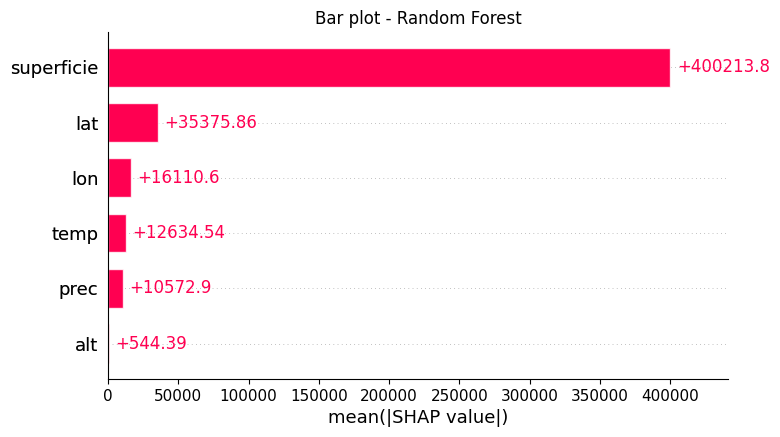

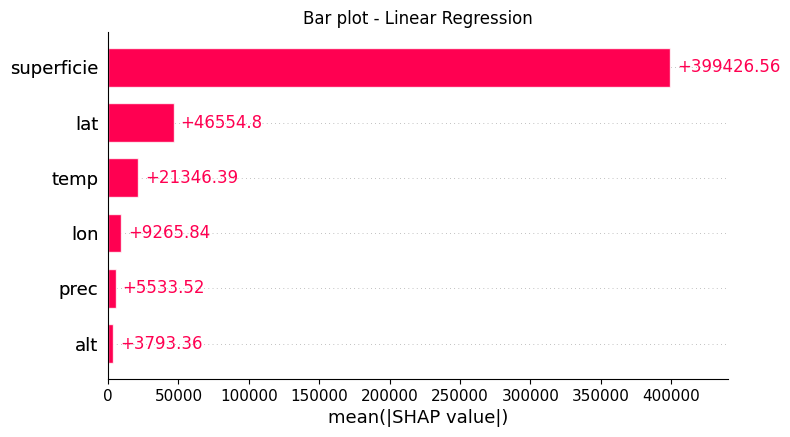

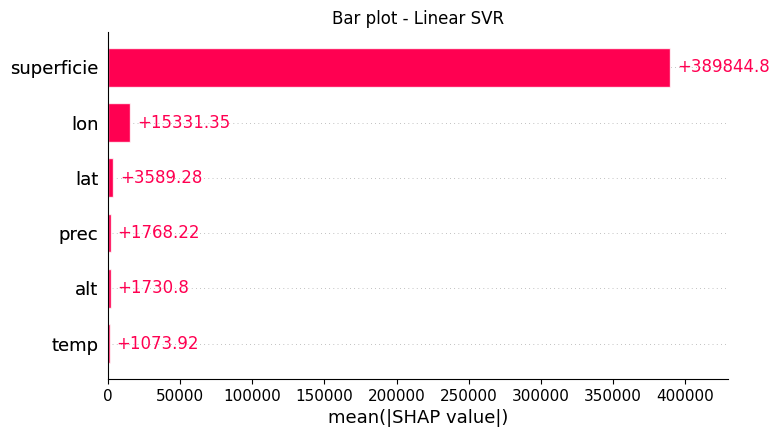

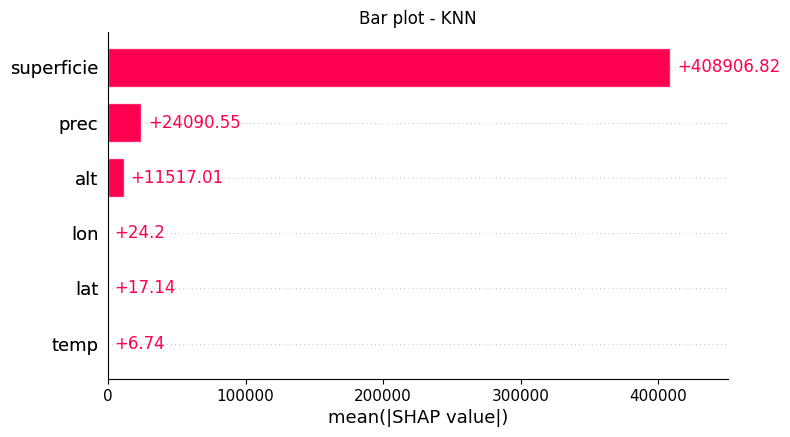

In [18]:
#bar plot for models
shap.plots.bar(shap_values_random_forest, show=False)
plt.title("Bar plot - Random Forest")
plt.show()

shap.plots.bar(shap_values_linear_regression, show=False)
plt.title("Bar plot - Linear Regression")
plt.show()

shap.plots.bar(shap_values_linear_svr, show=False)
plt.title("Bar plot - Linear SVR")
plt.show()

shap.plots.bar(shap_values_knn, show=False)
plt.title("Bar plot - KNN")
plt.show()

### SHAP Beeswarm Plot
Un beeswarm plot fornisce una visualizzazione più dettagliata e ricca delle caratteristiche del modello.

* Distribuzione dei valori SHAP: Ogni punto nel beeswarm plot rappresenta un singolo valore SHAP per una feature e un'osservazione. La posizione orizzontale del punto indica il valore SHAP, mentre la posizione verticale indica la feature a cui appartiene.
* Colore dei punti: I punti sono colorati in base ai valori delle caratteristiche originali (ad esempio, dal blu al rosso per valori bassi a valori alti). Questo aiuta a vedere la relazione tra i valori delle feature e il loro impatto sulla previsione.
* Densità dei punti: La disposizione a "sciame" dei punti lungo l'asse verticale mostra la densità dei valori SHAP. Le aree più dense indicano che ci sono molte osservazioni con valori SHAP simili per quella feature.

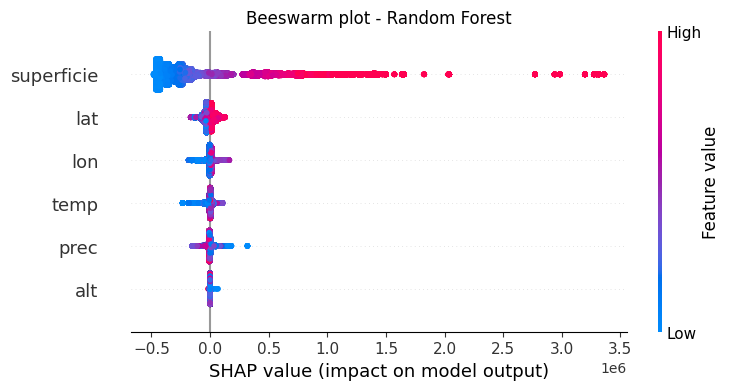

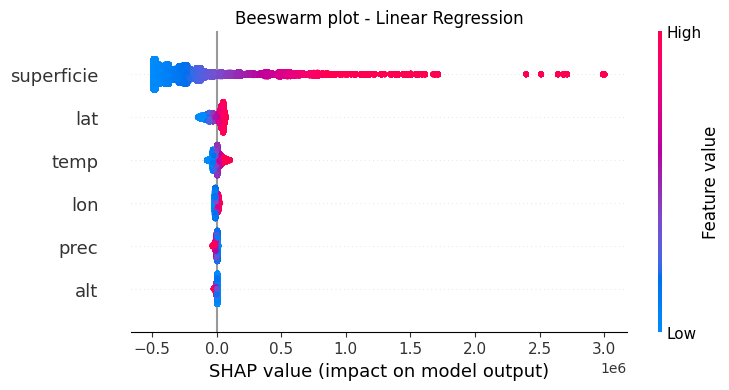

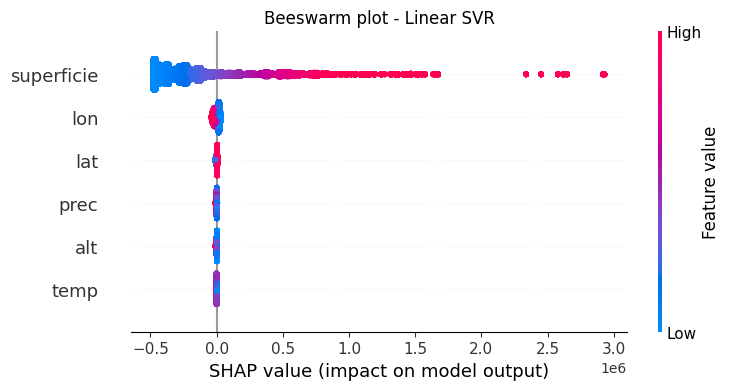

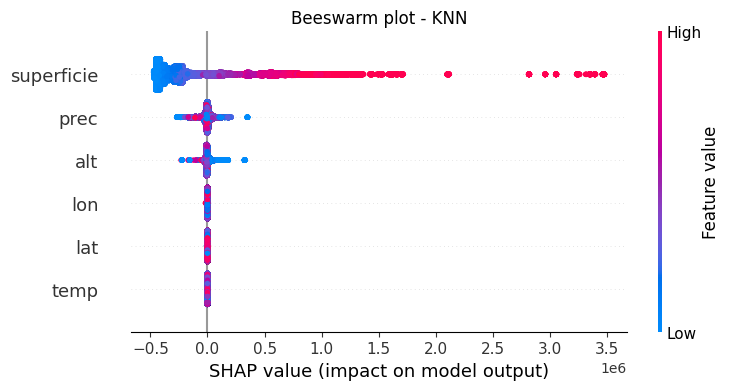

In [19]:
#beeswarm plot for models
shap.plots.beeswarm(shap_values_random_forest, show=False)
plt.title("Beeswarm plot - Random Forest")
plt.show()

shap.plots.beeswarm(shap_values_linear_regression, show=False)
plt.title("Beeswarm plot - Linear Regression")
plt.show()

shap.plots.beeswarm(shap_values_linear_svr, show=False)
plt.title("Beeswarm plot - Linear SVR")
plt.show()

shap.plots.beeswarm(shap_values_knn, show=False)
plt.title("Beeswarm plot - KNN")
plt.show()

### Riflessioni finali e conclusioni
Per ogni modello testato sul dataset sono stati calcolate varie metriche di performance, tra cui: Mean Absolute Error (MAE), Mean Squared Error (MSE), R-Squared (R²).

#### Random Forest
* MSE: 8,163,202.556987496
* RMSE: 1,438.9628035187102
* MAE: 108.5506828440529
* R²: 0.9999635409580774
* MAPE: 0.03514174943988976

#### Linear Regression
* MSE: 5,309,986,680.671545
* RMSE: 72,684.77164719318
* MAE: 49,128.35764009876
* R²: 0.9788057832287915
* MAPE: 105.7710883429407

#### Linear SVR
* MSE: 9,495,078,354.262794
* RMSE: 96,217.68934237148
* MAE: 59,063.06998909649
* R²: 0.9616235893080729
* MAPE: 69.63079053617965

#### K-Nearest Neighbors (KNN) Regressor
* MSE: 35,651,643.67786059
* RMSE: 5,318.468249698003
* MAE: 607.2187654083725
* R²: 0.9998542090680745
* MAPE: 0.6964405819267734

#### Considerazioni sulle metriche
Il modello Random Forest ha mostrato le migliori performance in quasi tutte le metriche, con un R² di 0.9999635409580774. \
Anche il modello KNN ha mostrato performance molto elevate, con un R² di 0.9998542090680745, ma con errori leggermente maggiori rispetto a Random Forest. \
Allo stesso tempo, Linear Regression e SVR hanno mostrato performance inferiori rispetto a Random Forest e KNN, con SVR che presenta le peggiori performance tra i quattro modelli analizzati.

Il MAE e il MAPE per Random Forest sono più bassi rispetto agli altri modelli, indicando che le sue predizioni sono molto più precise. \
KNN, pur avendo un MAPE leggermente più alto di Random Forest, si avvicina molto in termini di precisione. \
Linear Regression e SVR presentano errori di predizione molto più alti, con Linear Regression che ha un MAPE estremamente elevato, suggerendo che questo modello non è adatto per il dataset in questione.

### Analisi dei grafici SHAP

Per ovvie ragioni, in tutti i grafici SHAP, bar plot e beeswarm plot, la feature più importante di tutte è la superficie coltivata. \
Risulta comunque interessante vedere come le altre feature siano utilizzate e valutate in modo diverso da ogni modello. \
Ad esempio, la seconda feature più importante è diversa per ogni modello, essendoci modelli che per effettuare le previsioni danno più peso a feature come le precipitazioni, o le coordinate geografiche.

## Differenza tra dataset_final.csv e features.csv
1. dataset_final.csv: \
   Ogni riga rappresenta un comune italiano in un anno specifico, con variabili come superficie totale coltivata, produzione totale, precipitazioni e temperature per quell'anno.\
Questo dataset ha una granularità maggiore, permettendo ai modelli di apprendere le variazioni annuali nella produzione agricola in relazione ai cambiamenti climatici e ad altri fattori. \
Potrebbe però includere variabilità anno per anno, che può influenzare la capacità del modello di generalizzare bene.

2. features.csv \
Ogni riga rappresenta un comune italiano, con variabili aggregate con medie e deviazioni standard delle superfici coltivate, produzione, precipitazioni e temperature su un periodo di 16 anni (2006 - 2021).
L'aggregazione dei dati riduce la variabilità anno per anno, permettendo al modello di cogliere tendenze generali.
Allo stesso tempo, perde la granularità temporale.

### Confronto dei Risultati

Il modello con il dataset aggregato ha una performance leggermente migliore (MAE e MAPE più bassi) rispetto a quello con il dataset annuale, suggerendo che il dataset aggregato fornisce una previsione più accurata eliminando il rumore e le variazioni annuali.

### Conclusioni

1. Riduzione del Rumore \
L'aggregazione dei dati riduce la variabilità anno per anno, permettendo ai modelli di catturare meglio le tendenze generali e migliorare le loro performance.

2. Migliore Generalizzazione \
I modelli addestrati con il dataset aggregato tendono a generalizzare meglio risultando in predizioni più accurate e affidabili.

3. Scelta del Dataset \
Se l'obiettivo è catturare tendenze a lungo termine e migliorare la robustezza delle previsioni, l'aggregazione dei dati è la scelta migliore. \
Se si vogliono considerare le variazioni annuali specifiche, il dataset con granularità annuale può essere più utile.

In conclusione, l'aggregazione dei dati ha dimostrato di migliorare significativamente le performance dei modelli di machine learning in questo caso, rendendo le previsioni più accurate e stabili.